<a href="https://colab.research.google.com/github/LorenzoPeracchio/RelAI/blob/main/MS_reliability_diagnosticdelay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)
os.chdir('/content/drive/My Drive/...') # change the path


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

Mounted at /content/drive


In [2]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

Import dataset

In [4]:
subtask = "A"
df_train_static = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-static-vars.csv") #static variables
df_train_lcmm = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-lcmm.csv") #lcmm latent classes
df_train_outcome = pd.read_csv(f"dataset{subtask}_train_MS/dataset{subtask}_train/dataset{subtask}_train-outcomes.csv")
df_test_static = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-static-vars.csv")
df_test_lcmm = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-lcmm.csv")
df_test_outcome = pd.read_csv(f"dataset{subtask}_test_MS/dataset{subtask}_test/dataset{subtask}_test-outcomes.csv")

Dataset preprocessing

In [5]:
df_test_lcmm["patient_id"] = df_test_lcmm["patient_id"].str.strip() #remove whitespaces at beginning/end if any
df_train_lcmm["patient_id"] = df_train_lcmm["patient_id"].str.strip()

In [6]:
def nan_cleaner(df, nan_perc=.8, clean_rows = True):
  """Removal of features containing more than x% of NaN (and rows with at leas one NaN, optionally)"""
  original_shape = df.shape
  print("DataFrame shape before NaN removal:", original_shape)
  df = df.dropna(thresh=round(original_shape[0]*0.80),axis=1)
  if clean_rows and df.isnull().any().any():  # If there's at least one column with NaN
    df = df.dropna(axis=0, how='any')
    print("Perc removed rows: %.2f" % ((original_shape[0] - df.shape[0]) / original_shape[0] * 100))
  print("DataFrame shape after NaN removal:", df.shape)
  return df

def factorizer(df):
  """Factorizing string and boolean types"""
  string_cols = np.where((df.dtypes=="object") | (df.dtypes=="bool"))[0]
  mappings = {}
  for string_col in string_cols:
    if string_col==0: continue # skip first column (patient_id)
    df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
    mappings[df.columns[string_col]]={mapping[i]:i for i in range(len(mapping))}
  return df, mappings

In [7]:
df_train_static_augmented = pd.merge(df_train_static, df_train_lcmm, on = "patient_id")
df_train_static_augmented.rename(columns={'class':'latent_class_lcmm'}, inplace=True)

df_test_static_augmented = pd.merge(df_test_static, df_test_lcmm, on = "patient_id")
df_test_static_augmented.rename(columns={'class':'latent_class_lcmm'}, inplace=True)

In [8]:
# remove NaNs and map strings and bools to nums (same mapping will be applied to test set)
df_train_pp, mappings = factorizer(nan_cleaner(df_train_static_augmented))

# join static vars and outcomes in a single data frame through patient_id
df_train_pp = pd.merge(df_train_pp, df_train_outcome, left_on = "patient_id", right_on = "patient_id")
df_train_pp = df_train_pp.drop(columns=["patient_id"]) # drop the ids
df_train_pp = df_train_pp.drop(columns=["outcome_time"]) # we have more than 1 outcome in the dataset --> keep only the desired one

# for the test set, we apply the same factorization mapping used for training set
df_test_pp = df_test_static_augmented.replace(mappings)
test_patient_ids = df_test_pp["patient_id"]
df_test_pp = pd.merge(df_test_pp, df_test_outcome, left_on = "patient_id", right_on = "patient_id")
df_test_pp = df_test_pp.drop(columns=["patient_id"]) # drop the ids

df_test_pp['ethnicity'].fillna(0, inplace=True)
df_test_pp.loc[df_test_pp['ethnicity'] == 'Hispanic', 'ethnicity'] = -1
df_test_pp.loc[df_test_pp['ethnicity'] == 'Black_African', 'ethnicity'] = 1

DataFrame shape before NaN removal: (439, 15)
Perc removed rows: 8.66
DataFrame shape after NaN removal: (401, 15)


<ipython-input-6-edf21e375868>:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
<ipython-input-6-edf21e375868>:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
<ipython-input-6-edf21e375868>:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newval

In [9]:
pred_col = 'outcome_occurred'

y_train = df_train_pp[pred_col]
X_train = df_train_pp.drop(columns=[pred_col])
y_test = df_test_pp[pred_col]
X_test = df_test_pp.drop(columns=[pred_col,'outcome_time'])

y_train = y_train[X_train['centre']==0]
y_test = y_test[X_test['centre']==0]
X_train = X_train.loc[X_train['centre']==0]
X_test = X_test.loc[X_test['centre']==0]

drop_ix = X_test.loc[pd.isna(X_test).any(1), :].index
X_test = X_test.dropna(axis=0, how='any')
y_test = y_test.drop(index=drop_ix)

oversample = RandomOverSampler(sampling_strategy='minority', random_state=17)
X_over, y_over = oversample.fit_resample(X_train, y_train)

y_train = pd.Series(y_over, name='outcome_occurred')
X_train = pd.DataFrame(X_over, columns=X_train.columns)

<ipython-input-9-85860eb9b26f>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  drop_ix = X_test.loc[pd.isna(X_test).any(1), :].index


Select the threshold of diagnostic_delay to make the dataset shift

In [10]:
days_thresh = 500

X_train_in = X_train.loc[(X_train['diagnostic_delay'] <= days_thresh)]
X_train_out = X_train.loc[(X_train['diagnostic_delay'] > days_thresh)]
y_train_in = y_train.loc[(X_train['diagnostic_delay'] <= days_thresh)]
y_train_out = y_train.loc[(X_train['diagnostic_delay'] > days_thresh)]

X_test_in = X_test.loc[(X_test['diagnostic_delay'] <= days_thresh)]
X_test_out = X_test.loc[(X_test['diagnostic_delay'] > days_thresh)]
y_test_in = y_test.loc[(X_test['diagnostic_delay'] <= days_thresh)]
y_test_out = y_test.loc[(X_test['diagnostic_delay'] > days_thresh)]

X_in = pd.concat([X_train_in,], ignore_index = True)
y_in = pd.concat([y_train_in,], ignore_index = True)
X_out = pd.concat([X_train_out,X_test_out,X_test_in], ignore_index = True)
y_out = pd.concat([y_train_out,y_test_out,y_test_in], ignore_index = True)

Train-val-test split: the training and validation sets are completely in-distribution, while the test set has some in-distribution samples and all the out-of-distribution samples

In [11]:
#Training-Val-Test split

X_in_np = np.asarray(X_in)
y_in_np = np.asarray(y_in)
X_train_np, X_val_np,  y_train_np, y_val_np = train_test_split(X_in_np, y_in_np, random_state = 42, stratify = y_in_np)
X_test_np = np.asarray(X_out)
y_test_np = np.asarray(y_out)

In [12]:
X_train_df = pd.DataFrame(X_train_np, columns = X_train.columns)
X_val_df = pd.DataFrame(X_val_np, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_np, columns = X_train.columns)

X_train_diagnostic_delay = X_train_df['diagnostic_delay']
X_val_diagnostic_delay = X_val_df['diagnostic_delay']
X_test_diagnostic_delay = X_test_df['diagnostic_delay']

X_train_df = X_train_df.drop(columns=['diagnostic_delay', 'time_since_onset', 'centre'])
X_val_df = X_val_df.drop(columns=['diagnostic_delay', 'time_since_onset', 'centre'])
X_test_df = X_test_df.drop(columns=['diagnostic_delay', 'time_since_onset', 'centre'])

In [14]:
X_train_np = np.asarray(X_train_df)
X_val_np = np.asarray(X_val_df)
X_test_np = np.asarray(X_test_df)

In [15]:
def normalize_range(X, xtrainmin, xtrainmax):
  X_norm = []
  for i in range(X.shape[0]):
    vec_temp = []
    for j in range(X.shape[1]):
      if xtrainmin[j] == xtrainmax[j]:
        norm_x = X[i,j]
      else:
        norm_x = 2*(X[i,j]-xtrainmin[j])/(xtrainmax[j]-xtrainmin[j])-1
      vec_temp.append(norm_x)
    X_norm.append(vec_temp)
  return np.asarray(X_norm)

def denormalize_range(norm_x, xtrainmin, xtrainmax):
  denorm_x = []
  for j in range(len(norm_x)):
    if xtrainmin == xtrainmax:
      denorm_x.append(norm_x[j])
    else:
      denorm_x.append(((norm_x[j]+1)*(xtrainmax-xtrainmin))/2+xtrainmin)
  return np.asarray(denorm_x)


def denormalize_range_dataset(X, xtrainmin, xtrainmax):
  X_denorm = []
  for i in range(X.shape[1]):
    X_denorm.append(denormalize_range(X[:, i], xtrainmin[i], xtrainmax[i]))
  return X_denorm

In [16]:
X_train_np_min = []
X_train_np_max = []
X_train_np_mean = []
X_train_np_std = []

for i in range(len(X_train_np[0,:])):
  vec = X_train_np[:,i]
  X_train_np_min.append(min(vec))
  X_train_np_max.append(max(vec))

X_train_np = normalize_range(X_train_np, X_train_np_min, X_train_np_max)
X_val_np = normalize_range(X_val_np, X_train_np_min, X_train_np_max)
X_test_np = normalize_range(X_test_np, X_train_np_min, X_train_np_max)

Train a classifier on the training set, this classifier is the model whose predictive reliability is under exam

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clf = RandomForestClassifier(random_state=1, min_samples_leaf=20,n_estimators=500)
clf.fit(X_train_np, y_train_np)

RandomForestClassifier(min_samples_leaf=20, n_estimators=500, random_state=1)

Classifier's performance on the training, validation, and test sets

In [18]:
from sklearn.metrics import balanced_accuracy_score
print("CLF Balanced Accuracy\n")
print("Train set:", balanced_accuracy_score(y_train_np, clf.predict(X_train_np)))
print("Val set:  ", balanced_accuracy_score(y_val_np, clf.predict(X_val_np)))
print("Test set: ", balanced_accuracy_score(y_test_np, clf.predict(X_test_np)))

CLF Balanced Accuracy

Train set: 0.7622448979591837
Val set:   0.6785037878787878
Test set:  0.5730574324324325


RELIABILITY METHOD

In [19]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [20]:
from ReliabilityPackage.ReliabilityFunctions import *

EPOCH 1
EPOCH 2
.
.
.
EPOCH 9999
EPOCH 10000


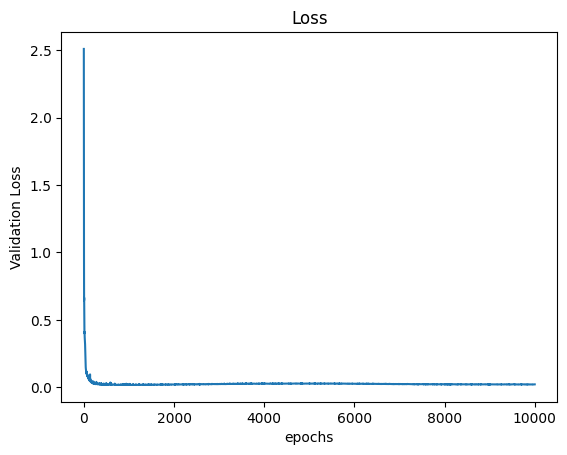

In [21]:
ae = create_and_train_autoencoder(X_train_np, X_val_np, batchsize=300, epochs=10000, optimizer_params = {'lr': 0.01, 'weight_decay': 1e-8})

In [22]:
syn_pts, acc_syn_pts = generate_synthetic_points("classification", clf.predict, X_train_np, y_train_np, method="GN", k = 5)

In [23]:
mse_thresh = perc_mse_threshold(ae, X_train_np, perc=100)
acc_thresh = 0.60

In [25]:
RD = create_reliability_detector("classification", ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


We are only interested in the "Density Principle Reliability", thus it is selected the "density" mode of the reliability method

In [26]:
#Test set Reliability
test_reliability= compute_dataset_reliability(RD, X_test_np, mode='density')
reliable_test = X_test_np[np.where(test_reliability == 1)]
y_reliable_test = y_test_np[np.where(test_reliability == 1)]
ypred_reliable_test = clf.predict(reliable_test)
unreliable_test = X_test_np[np.where(test_reliability == 0)]
y_unreliable_test = y_test_np[np.where(test_reliability == 0)]
ypred_unreliable_test = clf.predict(unreliable_test)
reliable_test_diagnostic_delay = X_test_diagnostic_delay.loc[(test_reliability == 1)]
unreliable_test_diagnostic_delay = X_test_diagnostic_delay.loc[(test_reliability == 0)]
#Training set Reliability
train_reliability= compute_dataset_reliability(RD, X_train_np, mode='density')
reliable_train = X_train_np[np.where(train_reliability == 1)]
y_reliable_train = y_train_np[np.where(train_reliability == 1)]
ypred_reliable_train = clf.predict(reliable_train)
unreliable_train = X_train_np[np.where(train_reliability == 0)]
y_unreliable_train = y_train_np[np.where(train_reliability == 0)]
# ypred_unreliable_train = clf.predict(unreliable_train)
#Validation set Reliability
val_reliability= compute_dataset_reliability(RD, X_val_np, mode='density')
reliable_val = X_val_np[np.where(val_reliability == 1)]
y_reliable_val = y_val_np[np.where(val_reliability == 1)]
ypred_reliable_val = clf.predict(reliable_val)
unreliable_val = X_val_np[np.where(val_reliability == 0)]
y_unreliable_val = y_val_np[np.where(val_reliability == 0)]
ypred_unreliable_val = clf.predict(unreliable_val)

% of reliability in the training, validation, and test sets

In [27]:
print("Train set:")
print("Reliable:", reliable_train.shape[0], "(",reliable_train.shape[0]/train_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_train.shape[0], "(",unreliable_train.shape[0]/train_reliability.shape[0]*100,"%)")

print("\nVal set:")
print("Reliable:", reliable_val.shape[0], "(",reliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_val.shape[0], "(",unreliable_val.shape[0]/val_reliability.shape[0]*100,"%)")

print("\nTest set:")
print("Reliable:", reliable_test.shape[0], "(",reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_test.shape[0], "(",unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")

Train set:
Reliable: 193 ( 100.0 %)
Unreliable: 0 ( 0.0 %)

Val set:
Reliable: 44 ( 67.6923076923077 %)
Unreliable: 21 ( 32.30769230769231 %)

Test set:
Reliable: 62 ( 30.693069306930692 %)
Unreliable: 140 ( 69.3069306930693 %)


In [28]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef, average_precision_score, brier_score_loss

def compute_metrics(y, ypred):
  scores = []
  scores.append(balanced_accuracy_score(y, ypred))
  scores.append(precision_score(y, ypred))
  scores.append(recall_score(y, ypred))
  scores.append(roc_auc_score(y, ypred))
  scores.append(f1_score(y, ypred))
  scores.append(matthews_corrcoef(y, ypred))
  scores.append(average_precision_score(y, ypred))
  scores.append(brier_score_loss(y, ypred))

  return scores

In [29]:
#Function to plot the metrics' plots
def metrics_plots(y, ypred, rel_y, rel_ypred, unrel_y, unrel_ypred, name):
  fig, ax = plt.subplots(figsize=(19, 7))
  xbarplot = np.arange(8)
  y1barplot = compute_metrics(y, ypred)
  y2barplot = compute_metrics(rel_y, rel_ypred)
  y3barplot = compute_metrics(unrel_y, unrel_ypred)

  bar_width = 0.27

  b1 = ax.bar(xbarplot, y1barplot, width = bar_width, color='steelblue')
  b2 = ax.bar(xbarplot+bar_width, y2barplot, width = bar_width, color='lightgreen')
  b3 = ax.bar(xbarplot+2*(bar_width), y3barplot, width = bar_width, color='salmon')

  ax.set_xticks(xbarplot + 2*(bar_width) / 2)
  ax.set_xticklabels(['Balanced Accuracy', 'Precision','Recall','AUC', 'f1-score', 'MCC', 'PRC', 'Brier Score'], fontsize=14)
  ax.legend([name,"Reliable "+name, "Unreliable "+name], fontsize=11)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  # Add axis and chart labels.
  ax.set_title('Performance '+name, pad=15, fontsize=18)

  for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = round(bar.get_height(),3)
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = 'black'
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)

  # Set the fontsize for y-axis bar values
  ax.yaxis.set_tick_params(labelsize=10)
  #fig.tight_layout()

Classifier's performance on the total test set, and on its reliable and unreliable subsets as indetified by the reliability method

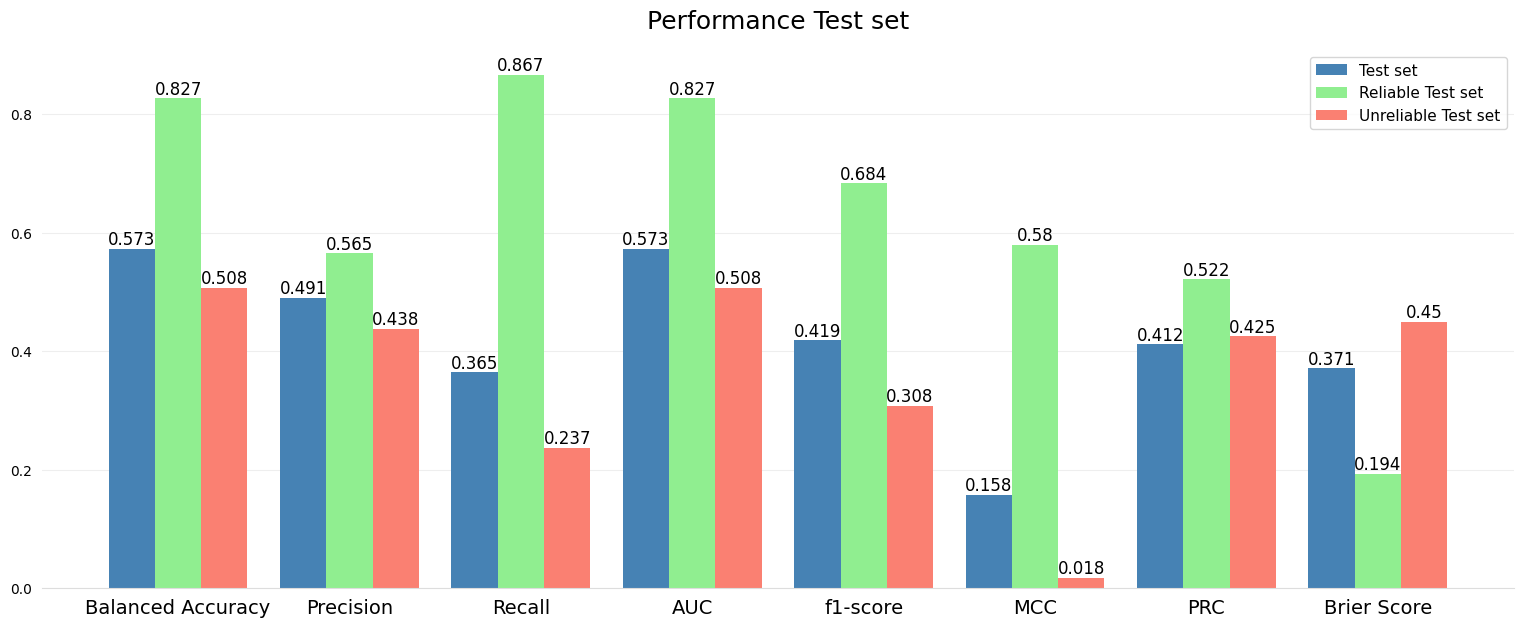

In [30]:
metrics_plots(y_test_np, clf.predict(X_test_np), y_reliable_test, ypred_reliable_test, y_unreliable_test, ypred_unreliable_test,'Test set')

De-normalization step to make the results more interpretable

In [31]:
denorm_reliable_test = reliable_test.copy()
denorm_unreliable_test = unreliable_test.copy()

for i in range(denorm_reliable_test.shape[1]):
  denorm_reliable_test[:,i] = denormalize_range_dataset(reliable_test, X_train_np_min, X_train_np_max)[i]
  denorm_unreliable_test[:,i] = denormalize_range_dataset(unreliable_test, X_train_np_min, X_train_np_max)[i]

df_test_rel = pd.DataFrame(denorm_reliable_test, columns = X_train_df.columns)
df_test_unrel = pd.DataFrame(denorm_unreliable_test, columns = X_train_df.columns)


df_test_rel['diagnostic_delay'] = np.asarray(reliable_test_diagnostic_delay)
df_test_unrel['diagnostic_delay'] = np.asarray(unreliable_test_diagnostic_delay)
df_test_rel['reliability'] = np.ones(reliable_test.shape[0])
df_test_unrel['reliability'] = np.zeros(unreliable_test.shape[0])
df_test_rel['real_class'] = y_reliable_test
df_test_unrel['real_class'] = y_unreliable_test

df_reliability_test = pd.concat([df_test_rel,df_test_unrel], ignore_index = True)

Distribution of diagnostic_delay in the reliable and unreliable subsets of the test set

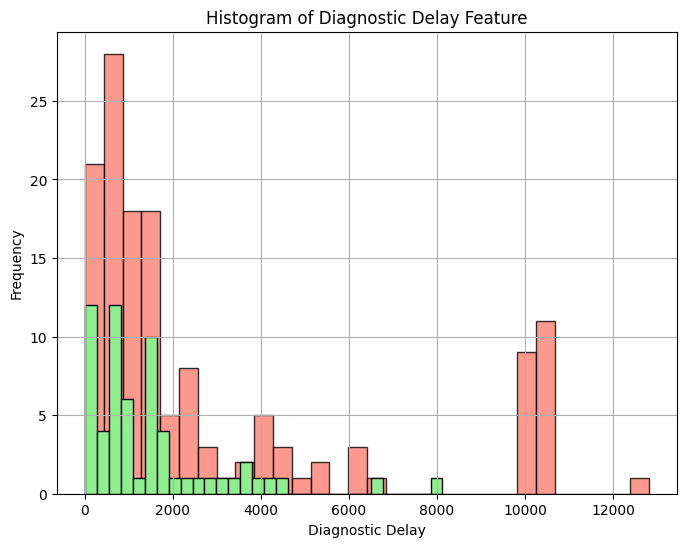

In [33]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(unreliable_test_diagnostic_delay, bins=30, color='salmon', edgecolor='black', alpha=0.8)
plt.hist(reliable_test_diagnostic_delay, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of Diagnostic Delay Feature')
plt.xlabel('Diagnostic Delay')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<Axes: ylabel='Density'>

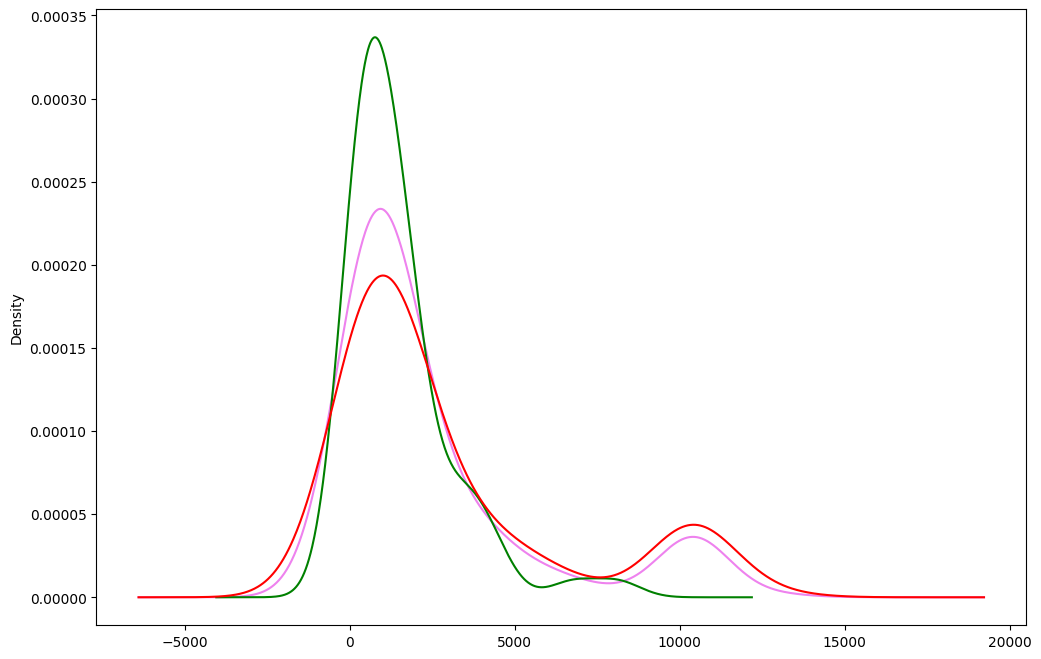

In [34]:
df_reliability_test['diagnostic_delay'].plot.kde(figsize=[12,8], color = 'violet')
reliable_test_diagnostic_delay.plot.kde(figsize=[12,8], color = 'green')
unreliable_test_diagnostic_delay.plot.kde(figsize=[12,8], color = 'red')

In [35]:
!pip install tableone

from tableone import TableOne

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [36]:
categorical = ['sex', 'residence_classification','ethnicity','ms_in_pediatric_age','spinal_cord_symptom','brainstem_symptom','eye_symptom','supratentorial_symptom','other_symptoms','latent_class_lcmm','real_class','reliability']

In [47]:
mytable = TableOne(df_reliability_test, categorical=categorical, nonnormal=['age_at_onset','diagnostic_delay'], groupby='reliability', pval=True, htest_name=False)

TABLE ONE OF THE RELIABLE AND UNRELIABLE SUBSETS OF THE TEST SET

In [49]:
print(mytable.tabulate(tablefmt = "github"))

|                                  |      | Missing   | Overall               | 0.0                   | 1.0                  | P-Value   |
|----------------------------------|------|-----------|-----------------------|-----------------------|----------------------|-----------|
| n                                |      |           | 202                   | 140                   | 62                   |           |
| sex, n (%)                       | 0.0  | 0         | 141 (69.8)            | 92 (65.7)             | 49 (79.0)            | 0.083     |
|                                  | 1.0  |           | 61 (30.2)             | 48 (34.3)             | 13 (21.0)            |           |
| residence_classification, n (%)  | 0.0  | 0         | 108 (53.5)            | 58 (41.4)             | 50 (80.6)            | <0.001    |
|                                  | 1.0  |           | 65 (32.2)             | 56 (40.0)             | 9 (14.5)             |           |
|                          

In [39]:
data_box_diag_feat = [ reliable_test_diagnostic_delay, unreliable_test_diagnostic_delay]

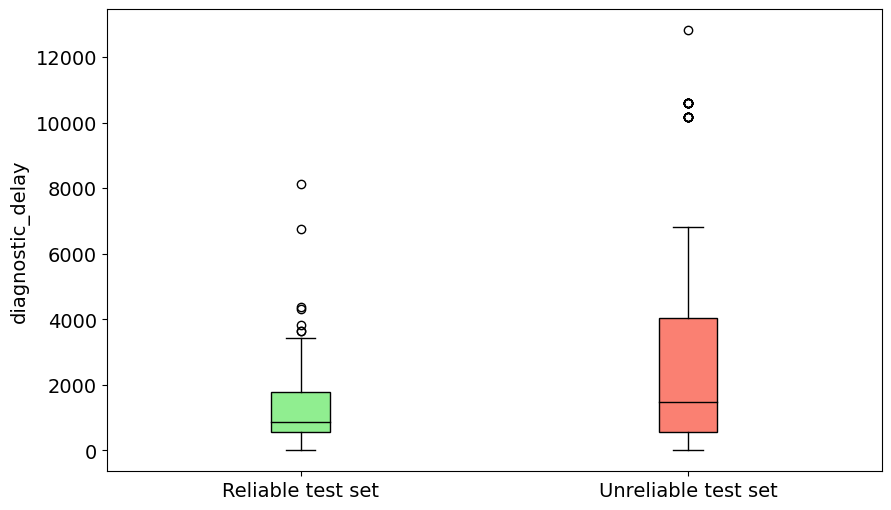

In [40]:
labels = ['Reliable test set','Unreliable test set']

fig, ax = plt.subplots(figsize=(10, 6))
# Creating plot
bplot1 = plt.boxplot(data_box_diag_feat, labels = labels, patch_artist=True, meanline=True)
# fill with colors
colors = [ 'lightgreen','salmon']

for patch, color in zip(bplot1['boxes'], colors):
  patch.set_facecolor(color)

for median in bplot1['medians']:
  median.set_color('black')

ax.set_ylabel('diagnostic_delay', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
plt.show()

Mean squared error distribution (computed by the autoencoder of the reliability method) of the training, validation, and test sets

In [41]:
mse_train_in_diag = []
for i in range(len(X_train_np)):
  mse_train_in_diag.append(mean_squared_error(X_train_np[i],  ae((torch.tensor(X_train_np[i, :])).float()).detach().numpy()))

mse_val_in_diag = []
for i in range(len(X_val_np)):
  mse_val_in_diag.append(mean_squared_error(X_val_np[i],  ae((torch.tensor(X_val_np[i, :])).float()).detach().numpy()))

mse_X_test_np = []
for i in range(len(X_test_np)):
  mse_X_test_np.append(mean_squared_error(X_test_np[i],  ae((torch.tensor(X_test_np[i, :])).float()).detach().numpy()))

In [42]:
data_mse_box_diag = [mse_train_in_diag, mse_val_in_diag, mse_X_test_np]

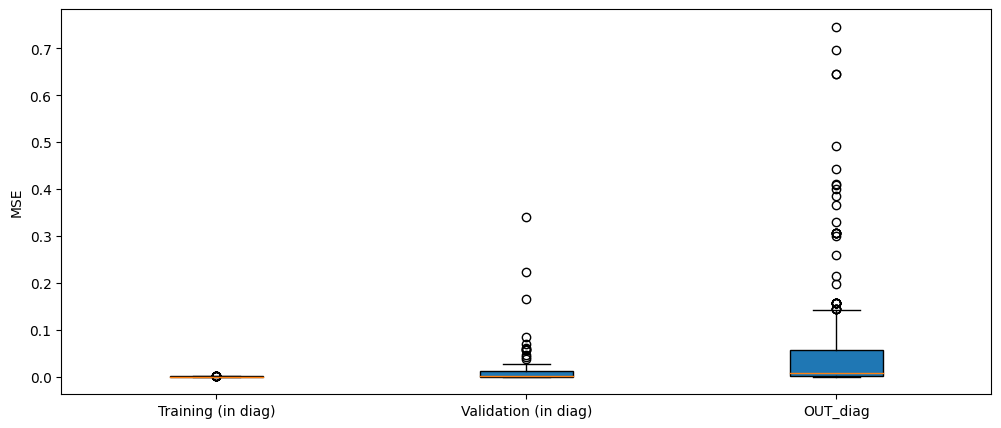

In [43]:
labels = ['Training (in diag)','Validation (in diag)','OUT_diag']
fig, ax = plt.subplots(figsize=(12, 5))
bplot1 = plt.boxplot(data_mse_box_diag, labels = labels, patch_artist=True)
ax.set_ylabel('MSE')
plt.show()